# Homework 3

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-04-14

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

In [1]:
import pandas as pd
import numpy as np
import datetime
import holidays
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.optimize import fsolve

# The code is made with the help of OpenAI's ChatGPT.

This homework relies on:

- the corporate and government bonds symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`, containing EOD price data as of 2024-12-13.
- the corporate bonds call schedule file `call_schedules`.


-----------------------------------------------------------
# Problem 1: Different types of bond yields and durations (fixed income recap)

### A. Continuously compounded (exponential) yields
In Lecture 1 we introduced the continuously compounded (exponential) yield $y$, used to discount bonds with arbitrary/generic cashflows 

\begin{align}
\{c_i ,T_i\}_{i=1..n}
\end{align} 

via the valuation formula

\begin{align}
B(y)=\sum_{i=1}^{n}c_{i}\cdot e^{-T_{i}\cdot y}
\end{align}

We then defined the bond duration $D$ (also called Macaulay duration) as the log-sensitivity of the bond price with respect to the exponential yield $y$:

\begin{align}
\frac{\partial B}{\partial y} = -B \cdot D
\end{align}

and showed that $D$ can be expressed as a weighted sum of time to maturities $T_i$

\begin{align}
D=\frac{\sum_{i=1}^{n}T_i \cdot c_{i}\cdot e^{-T_{i}\cdot y}}{\sum_{i=1}^{n}c_{i}\cdot e^{-T_{i}\cdot y}} = \sum_{i=1}^{n}T_i \cdot w_i
\end{align}

### B. Discretely compounded yields
For bonds with n regular coupon payment (coupon frequency = n), it is natural to define the discretely compounded yields $y_n$ (corresponding to the coupon frequency n):


\begin{align}
\left(1+\frac{y_{n}}{n}\right)^n=e^y
\end{align}

The most common cases in US fixed income markets are:

1. Semi-annual coupon frequency (e.g fixed rate USD bonds): the semi-annual yield $y_{sa} = y_2$ satisfies the formula

\begin{align}
\left(1+\frac{y_{sa}}{2}\right)^2=e^y
\end{align}

2. Quarterly coupon frequency (e.g floating rate USD bonds): the quarterly yield $y_{qt} = y_4$ satisfies the formula

\begin{align}
\left(1+\frac{y_{qt}}{2}\right)^4=e^y
\end{align}


3. Monthly coupon frequency (e.g USD loans): the monthly yield $y_{mo} = y_{12}$ satisfies the formula

\begin{align}
\left(1+\frac{y_{mo}}{12}\right)^{12}=e^y
\end{align}

As a general rule, discretely compunded yields are descreasing in the coupon frequency n:

\begin{align}
y_{sa} \geq y_{qt} \geq y_{mo} \geq y_{\infty} = y
\end{align}

### C. Modified duration
For a bond with n regular coupon payments, the modified duration $D_{mod}$ is defined as the log-sensitivity of the bond price with respect to the discretely compounded yield $y_n$:

\begin{align}
\frac{\partial B}{\partial y_{n}} = -B \cdot D_{mod}
\end{align}


In practice, when fixed income market participants talk about yields, DV01s and durations, they imply the type based on the cashflow frequency of the underlying instrument.

## To do:

### a. For fixed rate semi-annual USD bonds (frequency = 2), show that

\begin{align}
D_{mod} = D \cdot \left(1+\frac{y_{sa}}{2} \right)^{-1}
\end{align}


<b> Answered in the Word Document (PDF).

### b. In general, for bonds with n regular coupon payments (frequency = n), show that

\begin{align}
D_{mod} = D \cdot \left(1+\frac{y_{n}}{n} \right)^{-1}
\end{align}


<b> Answered in the Word Document (PDF).

-----------------------------------------------------------
# Problem 2: Callable bonds: "workout-date" and "yield-to-worst" calculations

In [2]:
import QuantLib as ql
import pandas as pd

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

## a. Load and explore the call schedules dataframe

Load the `call_schedules` Excel file into a dataframe. It contains call schedules for fixed-rate, callable corporate bonds.

For each bond in the dataframe, compute `num_call_dates`, the total number of outstanding calls.

In [3]:
# Call Schedule Dataframe

filepath_rawdata = f'./data/call_schedules.xlsx'
call_schedules_df = pd.read_excel(filepath_rawdata)

display(call_schedules_df.head())
display(call_schedules_df.tail())

,isin,figi,call_date,call_price
0,US345397D427,BBG01GXL4DP0,2030-03-10,100
1,US345397D591,BBG01K0V0QY0,2028-10-07,100
2,US345397E748,BBG01MVPX165,2027-04-17,100
3,US345397G313,BBG01QLGYZV3,2031-09-05,100
4,US34540TB359,BBG019LXFLX4,2026-03-20,100


,isin,figi,call_date,call_price
4445,US61747YFT73,BBG01NTC30T5,2035-07-14,100
4446,US61747YFT73,BBG01NTC30T5,2035-07-15,100
4447,US61747YFT73,BBG01NTC30T5,2035-07-16,100
4448,US61747YFT73,BBG01NTC30T5,2035-07-17,100
4449,US61747YFT73,BBG01NTC30T5,2035-07-18,100


In [4]:
# Group by ISIN
call_schedules_count_df = call_schedules_df[['isin', 'call_date']].groupby(['isin']).count()
call_schedules_count_df.columns = ['num_call_dates'] # Number of call dates for unique ISIN
display(call_schedules_count_df.head())
display(call_schedules_count_df.tail())

,num_call_dates
isin,
US037833BW97,1
US037833BX70,1
US037833BZ29,1
US037833CD08,1
US037833CH12,1


,num_call_dates
isin,
US92346MNW72,1
US92346MNY39,1
US92346MPA35,1
USU9221ABY39,1
USU9221ACH96,1


## b. Load the bond symbology dataframe and extend it with the fixed-rate callable corporate bond details from 1a.

Load the `bond_symbology` Excel file into a dataframe and keep only the fixed-rate callable bonds from 1a.

Extend the dataframe with the column computed in 1a:

| num_call_dates |
|----------|

In [5]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year

# Corporate Symbology Dataframe
symbology_corp = bond_symbology[(bond_symbology['class'] == 'Corp') & 
                      (bond_symbology['cpn_type'] == 'FIXED')
                      ]

# Symbology + Call_Schedules Dataframe
symbo_corp_call = pd.merge(symbology_corp, call_schedules_count_df, on=['isin'], how='inner')
display(symbo_corp_call.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM,num_call_dates
0,AAPL,Corp,BBG00C7QBCQ1,US037833BW97,US91282CLW90,AAPL 4 1/2 02/23/36,APPLE INC,GLOBAL,4.50,FIXED,...,2036-02-23,CALLABLE,Sr Unsecured,1250.0,US,USD,ACTV,20.000000,11.195072,1
1,AAPL,Corp,BBG00C7QBG91,US037833BX70,US912810UF39,AAPL 4.65 02/23/46,APPLE INC,GLOBAL,4.65,FIXED,...,2046-02-23,CALLABLE,Sr Unsecured,4000.0,US,USD,ACTV,30.001369,21.196441,1
2,AAPL,Corp,BBG00DHQX240,US037833BZ29,US91282CLY56,AAPL 2.45 08/04/26,APPLE INC,GLOBAL,2.45,FIXED,...,2026-08-04,CALLABLE,Sr Unsecured,2250.0,US,USD,ACTV,9.998631,1.639973,1
3,AAPL,Corp,BBG00DHQX9M5,US037833CD08,US912810UF39,AAPL 3.85 08/04/46,APPLE INC,GLOBAL,3.85,FIXED,...,2046-08-04,CALLABLE,Sr Unsecured,2000.0,US,USD,ACTV,29.998631,21.639973,1
4,AAPL,Corp,BBG00FXTS8Z0,US037833CJ77,US91282CMB45,AAPL 3.35 02/09/27,APPLE INC,GLOBAL,3.35,FIXED,...,2027-02-09,CALLABLE,Sr Unsecured,2250.0,US,USD,ACTV,9.998631,2.157426,1


## c. Add a function to compute "yield-to-maturity",  "yield-to-worst" and "workout date" for a fixed-rate callable bond

Quick recap: given the current market price, the issuer is expected to call a callable bond on the call date corresponding to lowes "yield to call date".

This corresponds to the best possible scenario from the point of view of the issuer exercising the call option (and the worst possible scenario from the point of view of the bond investor).

The lowest possible yield on a call date is called the "yield-to-worst" and the corresponding call date (on which the issuer is expected to call the bond) is called the "workout date". 

Keep in mind that the "workout date" could be the bond maturity date, in which case "yield-to-worst" = "yield-to-maturity".

To do: for a callable fixed-rate bond with known symbology (reference data) and call schedules dataframes, create a function that takes the clean market price as an input and returns the "yield-to-maturity, "yield-to-worst and "workout date".

1. Compute the yield to maturrity first.
2. For each  call date, create the corresponding "call scenario" bond object (using the call date as maturity).
3. Compute the corresponding "call scenario yield" (using the bond clean market price as input).
4. Identify "workout date" and "yield-to-worst".


In [6]:
def calc_yield_to_worst(
            details: dict,
            pc_schedule: pd.DataFrame,
            bond_clean_price: float,
            calc_date: ql.Date):
    '''Computes yield-to-worst and workout date for fixed rate callable bonds.
        Inputs:
        details: dict with keys 'maturity'
        pc_schedule: DataFrame with 'call_date' column (datetime.date or pd.Timestamp)
        bond_clean_price: market price of the bond (clean)
        calc_date: ql.Date object representing the pricing date
        
    '''
    # Basic bond inputs
    maturity_date = details['maturity']
    compounding = ql.Compounded
    coupon_freq = ql.Semiannual
    
    # Create a base case bond (to maturity) and compute yield_to_maturity
    bond_object = create_bond_from_symbology(details)
    
    # 2 ways to obtain yield_to_maturity: Market Yield vs Quantlib
    # yield_to_maturity = details['yield_to_maturity']
    yield_to_maturity = bond_object.bondYield(bond_clean_price, bond_object.dayCounter(), compounding, coupon_freq) * 100
    
    # Start with Maturity and yield_to_maturity (base case)
    workout_date = maturity_date
    yield_to_worst = yield_to_maturity
    
    # Keep schedules for used bond only
    used_pc_schedule = pc_schedule[pc_schedule['isin'] == details['isin']]
    
    for index, row in used_pc_schedule.iterrows():
        call_date = row['call_date']
        if get_ql_date(call_date) > calc_date:
            
            # Create a call scenario details df
            call_scenario_details = details.copy()
            call_scenario_details['maturity'] = row['call_date'] # Treat the call_date as maturity
            call_scenario_bond_object = create_bond_from_symbology(call_scenario_details)
            
            # Scenario Yield (treating the call date as maturity)
            call_scenario_yield = call_scenario_bond_object.bondYield(bond_clean_price, call_scenario_bond_object.dayCounter(), compounding, coupon_freq) * 100
            
            # Update yield_to_worst and workout_date if needed
            if call_scenario_yield < yield_to_worst:
                print('Found new workout date:', details['isin'], workout_date, call_date, yield_to_worst, call_scenario_yield)
                
                yield_to_worst = call_scenario_yield
                workout_date = call_date

    return yield_to_maturity, yield_to_worst, workout_date

## d. Compute "workout dates" and "yields-to-worst" for all Oracle fixed-rate callable bonds

Load the `bond_market_prices_eod` Excel file into a dataframe, which contains market quotes as of 2024-12-13.

For each Oracle fixed-rate callable bond in the symbology dataframe (ticker = 'ORCL'):
- 1. Compute the yield to maturity (using clean market prices)

- 2. Use the function from 1c to compute "workout date" and "yield-to-worst".

Extend the symbology dataframe with the following columns:


| clean_price |  yield_to_maturity | yield_to_worst | workout_date |
|----------|-------------|-------|-------------|

Which ORCL callable bonds are expected to be called early, i.e. have workout_date < maturity? There should be 3 of them!


In [7]:
# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['clean_price'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
display(data_market.head(3))

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,clean_price,midYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132,93.5185,5.156
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194,63.9775,5.218
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205,63.9655,5.229


In [8]:
# Merge with Market Price
combined_df = pd.merge(symbo_corp_call, data_market, on=['isin', 'figi', 'class', 'ticker'], how='inner')

# add dummy yield_to_maturity, yield_to_worst and workout_date columns, to be populated later
combined_df['yield_to_maturity'] = 0.0
combined_df['yield_to_worst'] = 0.0
combined_df['workout_date'] = combined_df['maturity']

df_oracle = combined_df[combined_df['ticker'] == 'ORCL']

display(df_oracle[['isin', 'ticker', 'coupon', 'maturity', 
                                 'num_call_dates', 'clean_price', 'yield_to_maturity', 'yield_to_worst','workout_date']].head(10))

,isin,ticker,coupon,maturity,num_call_dates,clean_price,yield_to_maturity,yield_to_worst,workout_date
61,US68389XAV73,ORCL,4.300,2034-07-08,1,93.1480,0.0,0.0,2034-07-08
62,US68389XAW56,ORCL,4.500,2044-07-08,1,85.9360,0.0,0.0,2044-07-08
63,US68389XBD66,ORCL,3.250,2030-05-15,1,92.2565,0.0,0.0,2030-05-15
64,US68389XBE40,ORCL,3.900,2035-05-15,1,88.9615,0.0,0.0,2035-05-15
65,US68389XBF15,ORCL,4.125,2045-05-15,1,80.5770,0.0,0.0,2045-05-15
66,US68389XBG97,ORCL,4.375,2055-05-15,1,80.2530,0.0,0.0,2055-05-15
67,US68389XBM65,ORCL,2.650,2026-07-15,1,97.0100,0.0,0.0,2026-07-15
68,US68389XBH70,ORCL,3.850,2036-07-15,1,86.8270,0.0,0.0,2036-07-15
69,US68389XBJ37,ORCL,4.000,2046-07-15,1,78.5130,0.0,0.0,2046-07-15
70,US68389XBN49,ORCL,3.250,2027-11-15,1,96.2925,0.0,0.0,2027-11-15


In [9]:
# Apply to dataframe
for index, row in combined_df.iterrows():
    details = row.to_dict() # Convert to dictionaries
        
    bond_clean_price = details['clean_price']
    
    yield_to_maturity, yield_to_worst, workout_date = calc_yield_to_worst(details, call_schedules_df, bond_clean_price, calc_date)
    
    combined_df.loc[index, 'yield_to_maturity'] = yield_to_maturity
    combined_df.loc[index, 'yield_to_worst'] = yield_to_worst
    combined_df.loc[index, 'workout_date'] = workout_date

Found new workout date: US68389XCH61 2029-11-09 00:00:00 2029-09-09 00:00:00 4.8846540451049805 4.845641074661292
Found new workout date: US68389XCJ28 2032-11-09 00:00:00 2032-08-09 00:00:00 5.135895729064941 5.107214927673341
Found new workout date: US68389XCK90 2052-11-09 00:00:00 2052-05-09 00:00:00 5.8574152469635 5.850478696823119


In [10]:
# Which ORCL callable bonds are expected to be called early, i.e. have workout_date < maturity? There should be 3 of them!
df_oracle_early = combined_df[combined_df['maturity'] != combined_df['workout_date']]

print('Bonds with workout_date < maturity (early call):')
display(df_oracle_early[['isin', 'ticker', 'security', 'maturity', 'clean_price', 'yield_to_maturity', 'yield_to_worst', 'workout_date']])

Bonds with workout_date < maturity (early call):


,isin,ticker,security,maturity,clean_price,yield_to_maturity,yield_to_worst,workout_date
84,US68389XCH61,ORCL,ORCL 6.15 11/09/29,2029-11-09,105.4465,4.884654,4.845641,2029-09-09
85,US68389XCJ28,ORCL,ORCL 6 1/4 11/09/32,2032-11-09,107.1520,5.135896,5.107215,2032-08-09
86,US68389XCK90,ORCL,ORCL 6.9 11/09/52,2052-11-09,114.2355,5.857415,5.850479,2052-05-09


-----------------------------------------------------------
# Problem 3: Risk & Scenario analysis for a fixed rate corporate bond (yield model)
## Use the QuantLib Basic notebook (or previous homeworks) as templates.

## a. Create generic fixed-rate corporate bond
Fix the calculation date as of December 13 2024 and use a coupon of 5% and a maturity of 10 years (December 13 2034).

Display the fixed rate bond cashflows.

In [11]:
# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

In [12]:
# Use the bond_details template below to quickly define the bond specs
test_bond_details = {'class': 'Corp',
                'start_date': '2024-12-13', 
                'acc_first': '2024-12-13', 
                'maturity': '2034-12-13', 
                'coupon': 5,
                'dcc' : '30/360',
                'days_settle' : 1}

# Use create_bond_from_symbology() to create the bond from the bond details dictionary
def create_bond_from_symbology(details: dict):
    '''Create a US fixed rate bond object from symbology details dictionary (usually one row of the symbology dataframe)
    '''
    
     # Create day_count from details['dcc']
     # For US Treasuries use ql.ActualActual(ql.ActualActual.ISMA)
     # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)
    # day_count = ql.Thirty360(ql.Thirty360.USA)   # update code depending on dcc !!!
    if details['dcc'] == 'ACT/ACT':
        day_count = ql.ActualActual(ql.ActualActual.ISMA)
    elif details['dcc'] == '30/360':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == '30/360 NON-EOM':
        day_count = ql.Thirty360(ql.Thirty360.USA)
    elif details['dcc'] == "ACT/360":
        day_count = ql.Actual360()
    else:
        raise ValueError(f"Unsupported day count convention: {details['dcc']}")
    
    # Create day_count from details['start_date']    
    issue_date = get_ql_date(details['start_date'])
    
    # Create days_settle from details['days_settle']
    days_settle = int(details['days_settle'])
    
    # Create coupon from details['coupon']
    coupon = float(details['coupon']) / 100
    
    # Create cashflow schedule
    schedule = create_schedule_from_symbology(details)
    
    face_value = 100
    redemption = 100
    
    payment_convention = ql.Unadjusted
        
    # Create fixed rate bond object
    fixed_rate_bond = ql.FixedRateBond(
        days_settle,
        face_value,
        schedule,
        [coupon],
        day_count,
        payment_convention,
        redemption,
        issue_date)        

    return fixed_rate_bond

def get_bond_cashflows(bond: ql.FixedRateBond, calc_date=ql.Date) -> pd.DataFrame:
    '''Returns all future cashflows as of calc_date, i.e. with payment dates > calc_date.
    takes the bond (in dictionary version) and date
    '''
    
    # all cash flows: 
    # x = [(cf.date(), cf.amount()) for cf in bond.cashflows()]

    # Future cash flows
    x = [(cf.date(), cf.amount()) for cf in bond.cashflows() if cf.date() > calc_date]
    cf_date_fixed, cf_amount = zip(*x)
     
    # create and display cashflows dataframe
    cashflows_df = pd.DataFrame(data={'CashFlowDate': cf_date_fixed, 'CashFlowAmount': cf_amount})
    
    # Adding column for year fraction
    cashflows_df["CashFlowYearFraction"] = cashflows_df.apply(lambda x: bond.dayCounter().yearFraction(calc_date, x["CashFlowDate"]), axis=1) 
    
    return cashflows_df

# Cash Flow Schedule
bond_details = test_bond_details
bond_test = create_bond_from_symbology(bond_details)
df_cashflow_bond_test = get_bond_cashflows(bond_test, calc_date)
display(df_cashflow_bond_test)

,CashFlowDate,CashFlowAmount,CashFlowYearFraction
0,"June 13th, 2025",2.5,0.5
1,"December 13th, 2025",2.5,1.0
2,"June 13th, 2026",2.5,1.5
3,"December 13th, 2026",2.5,2.0
4,"June 13th, 2027",2.5,2.5
5,"December 13th, 2027",2.5,3.0
6,"June 13th, 2028",2.5,3.5
7,"December 13th, 2028",2.5,4.0
8,"June 13th, 2029",2.5,4.5
9,"December 13th, 2029",2.5,5.0


## b. Compute the bond price, DV01, duration and convexity (analytic method).

Assume that the market yield of the bond is 6%. Compute the bond price, DV01, duration and convexity, using the analytic method.

In [13]:
# Bond Setup
bond = create_bond_from_symbology(bond_details) 
bond_yield = 6/100 # Given
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)

clean_price = bond.cleanPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)
dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)

# Bond Yield Rate (give specifications to the bond_yield)
bond_yield_rate = ql.InterestRate(bond_yield, bond.dayCounter(), compounding, coupon_freq)

# Use bond_yield_rate for Duration and Convexity
bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
dv01 = dirty_price * bond_duration / 100 # Use dirty price for DV01, duration, convexity

print(f"Clean Price: ${round(clean_price, 2)}")
print(f"Dirty Price: ${round(dirty_price, 2)}")
print(f"DV01: {round(dv01, 2)}")
print(f"Duration (years): {round(bond_duration, 2)}")
print(f"Convexity: {round(bond_convexity, 2)}")

Clean Price: $92.57
Dirty Price: $92.61
DV01: 7.09
Duration (years): 7.66
Convexity: 71.66


## c. Scenario bond prices: "re-pricing" vs "second-order approximations"

Compute the scenario bond prices on the following scenario yield grid: [from 1% to 11% in steps of 0.5%]

Compute the second-order scenario price approximations using duration and convexity sensitivities (formula 13 from Lecture 1).

\begin{align}
\Delta B(y) = B\left(y+\Delta y\right)-B\left(y\right)\approx B\cdot\left[- D\cdot\Delta y+\frac{1}{2}\cdot\Gamma\cdot\left(\Delta y\right)^{2}\right]
\end{align}

Plot the scenario prices (Y-axis) vs yieds (X-axis), for both the "re-pricing" and "second-order approximations" method.

In [14]:
# Scenario Bond Prices using Re-Pricing Method

# Yield increment per step
yield_step = 0.5/100
# New Yield 
new_yields = np.arange(1/100, 11.1/100, yield_step)

# List to store result:
prices = []

# Bond Setup
bond = create_bond_from_symbology(bond_details) # Use the bond from earlier
compounding = ql.Compounded
coupon_freq = ql.Semiannual

for new_yield in new_yields:
    # Re-compute the clean price using the new yield
    price_new = bond.cleanPrice(new_yield, bond.dayCounter(), compounding, coupon_freq)
    
    # Append to the list
    prices.append(price_new) 
    
# Create DataFrame 
df_repricing = pd.DataFrame({
    'New Yield (%)': new_yields * 100,
    'Price (Re-Pricing)': prices,
})
display(df_repricing)


,New Yield (%),Price (Re-Pricing)
0,1.0,137.944641
1,1.5,132.363856
2,2.0,127.047737
3,2.5,121.982740
4,3.0,117.156050
5,3.5,112.555546
6,4.0,108.169759
7,4.5,103.987833
8,5.0,99.999496
9,5.5,96.195023


In [15]:
# Scenario Bond Prices using Second Order Approximation

yield_step = 0.5/100
bond_yield = 0.06
new_yield = 0.01

yield_change = new_yield - bond_yield
price_change = dirty_price * ( (- bond_duration * yield_change) + 0.5 * bond_convexity * ((yield_change)**2) )
price_new = clean_price + price_change
print(f"New Price: ${round(price_new, 2)}")
print(f"Change in Price: ${round(price_change, 2)} due to a change in yield of: {round(yield_change,5)*100}%")

yield_step = 0.5/100
bond_yield = 0.06
new_yield += yield_step

yield_change = new_yield - bond_yield
price_change = dirty_price * ( (- bond_duration * yield_change) + 0.5 * bond_convexity * ((yield_change)**2) )
price_new = clean_price + price_change
print(f"New Price: ${round(price_new, 2)}")
print(f"Change in Price: ${round(price_change, 2)} due to a change in yield of: {round(yield_change,5)*100}%")

yield_step = 0.5/100
bond_yield = 0.06
new_yield += yield_step

yield_change = new_yield - bond_yield
price_change = dirty_price * ( (- bond_duration * yield_change) + 0.5 * bond_convexity * ((yield_change)**2) )
price_new = clean_price + price_change
print(f"New Price: ${round(price_new, 2)}")
print(f"Change in Price: ${round(price_change, 2)} due to a change in yield of: {round(yield_change,5)*100}%")

New Price: $136.31
Change in Price: $43.75 due to a change in yield of: -5.0%
New Price: $131.19
Change in Price: $38.63 due to a change in yield of: -4.5%
New Price: $126.24
Change in Price: $33.67 due to a change in yield of: -4.0%


In [16]:
# Scenario Bond Prices using Second Order Approximation

# Yield increment per step
yield_step = 0.5/100
new_yields = np.arange(1/100, 11.1/100, yield_step)

# Lists to store result:
prices = []
price_changes = []

bond_yield = 6/100 # Original yield

for new_yield in new_yields:
    
    # Change in Yield from the original yield
    yield_change = new_yield - bond_yield
    
    # Use dirty price for DV01, duration, convexity
    price_change = dirty_price * ( (- bond_duration * yield_change) + 0.5 * bond_convexity * ((yield_change)**2) )
    
    # As a starting point, use clean_price
    price_new = clean_price + price_change
    
    prices.append(price_new)
    price_changes.append(price_change)

# Create DataFrame
df_approx = pd.DataFrame({
    'New Yield (%)': new_yields * 100,
    'Yield Change (%)': yield_change,
    'Price (2nd Order Approx.)': prices,
    'Price Change (2nd Order Approx.)': price_changes
})
#display(df_approx)

# Merging dataframes
df_scenario_prices = df_repricing.copy()
df_scenario_prices['Yield Change (%)'] = df_approx['Yield Change (%)']
df_scenario_prices['Price (2nd Order Approx.)'] = df_approx['Price (2nd Order Approx.)']
display(df_scenario_prices.round(2))

,New Yield (%),Price (Re-Pricing),Yield Change (%),Price (2nd Order Approx.)
0,1.0,137.94,0.05,136.31
1,1.5,132.36,0.05,131.19
2,2.0,127.05,0.05,126.24
3,2.5,121.98,0.05,121.45
4,3.0,117.16,0.05,116.82
5,3.5,112.56,0.05,112.37
6,4.0,108.17,0.05,108.07
7,4.5,103.99,0.05,103.95
8,5.0,100.00,0.05,99.99
9,5.5,96.20,0.05,96.19


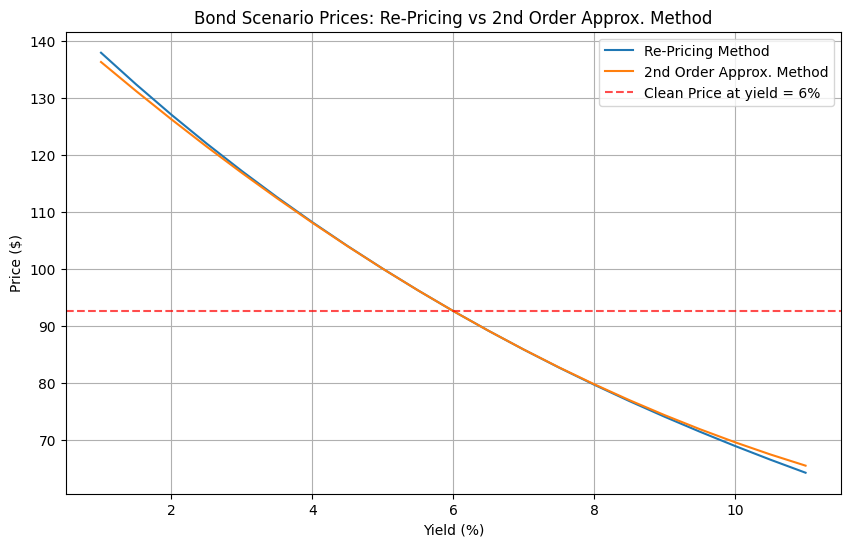

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df_scenario_prices['New Yield (%)'], df_scenario_prices['Price (Re-Pricing)'], label='Re-Pricing Method')
plt.plot(df_scenario_prices['New Yield (%)'], df_scenario_prices['Price (2nd Order Approx.)'], label='2nd Order Approx. Method')

# Line for original clean_price
plt.axhline(clean_price, color='red', linestyle='--', alpha=0.7, label = 'Clean Price at yield = 6%')

plt.title('Bond Scenario Prices: Re-Pricing vs 2nd Order Approx. Method')
plt.xlabel('Yield (%)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

## d. Extreme event scenarios

Compute and show the scenario bond price for a bond yield of 15% (extreme event scenario).

Compute and show the second-order scenario price approximation in the extreme event scenario.

Compute and show the analytic DV01, duration and convexity in the extreme event scenario.

How accurate is the second-order approximation (Taylor expansion using duration and convexity) in the extreme event case, and why?

In [18]:
# Scenario Bond Prices using Re-Pricing Method

# New Yield 
new_yield = 15/100

# Bond Setup
bond = create_bond_from_symbology(bond_details) # Use the bond from earlier
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# New Clean Price from the new yield
price_new_repricing = bond.cleanPrice(new_yield, bond.dayCounter(), compounding, coupon_freq)

print(f"New Price (Re-Pricing Method): ${round(price_new_repricing, 3)}")

New Price (Re-Pricing Method): $49.045


In [19]:
# Scenario Bond Prices using Second Order Approximation

bond_yield = 6/100 # Original Yield
new_yield = 15/100 # New Yield

yield_change = new_yield - bond_yield
price_change = dirty_price * ( (- bond_duration * yield_change) + 0.5 * bond_convexity * ((yield_change)**2) )
price_new_approx = clean_price + price_change

print(f"New Price (2nd Order Approx. Method): ${round(price_new_approx, 2)}")
# print(f"Change in Price: ${round(price_change, 2)} due to a change in yield of: {round(yield_change,2)*100}%")

New Price (2nd Order Approx. Method): $55.62


In [25]:
# Bond Setup
bond = create_bond_from_symbology(bond_details) 
compounding = ql.Compounded
coupon_freq = ql.Semiannual

# New Yield
bond_yield_extreme = 15/100 

clean_price_extreme = bond.cleanPrice(bond_yield_extreme, bond.dayCounter(), compounding, coupon_freq)
dirty_price_extreme = bond.dirtyPrice(bond_yield_extreme, bond.dayCounter(), compounding, coupon_freq)

# Bond Yield Rate (give specifications to the bond_yield)
bond_yield_rate_extreme = ql.InterestRate(bond_yield_extreme, bond.dayCounter(), compounding, coupon_freq)

# Use bond_yield_rate for Duration and Convexity
bond_duration_extreme = ql.BondFunctions.duration(bond, bond_yield_rate_extreme)
bond_convexity_extreme = ql.BondFunctions.convexity(bond, bond_yield_rate_extreme)
dv01_extreme = dirty_price_extreme * bond_duration_extreme / 100 # Use dirty price for DV01, duration, convexity

# Error = Approximated Price (2nd Order Approx.) - Clean Price from Re-Pricing
error = price_new_approx - price_new_repricing 

print("Extreme Event:")
print(f"DV01: {round(dv01_extreme, 2)}")
print(f"Duration (years): {round(bond_duration_extreme, 2)}")
print(f"Convexity: {round(bond_convexity_extreme, 2)}")

print(f"Approximation Error: {round(error, 2)}")

Extreme Event:
DV01: 3.16
Duration (years): 6.44
Convexity: 55.34
Approximation Error: 6.58


The second-order approximation (Taylor expansion using duration and convexity) in the extreme event case is not accurate because we are missing the 3rd, 4th, and higher order terms which are important when observing the price changes due to changes in yield. For small changes in yield, the effects of duration and convexity dominate the price change. But for big changes in yield, the higher order terms become increasingly more significant in capturing the non-linear behavior of the price-yield relationship. 

-----------------------------------------------------------
# Problem 4: Perpetual bonds
## a. Price a fixed rate perpetual bond
We are interested in a fixed rate perpetual bond (infinite maturity) on a face notional of $100 and semi-annual coupon c.

Assuming that the bond has a known continuously componded yield of y, what is the price of the perpetual bond (assume T+0 settlement and zero accrued)?

Use the definition of the semi-annual yield: $y_{sa} = 2 \cdot \left(e^{\frac{y}{2}}-1 \right)$.

You can use following sympy code (implementing Formula 5 from Session 1) as a starting point.

In [21]:
# import libraries
import sympy as sp

# define fixed rate bond specs as symbolic variables
T = sp.symbols('T')
c = sp.symbols('c')
y = sp.symbols('y')

# define symbolic equation for generic fixed rate bond pv
bond_pv_eq =  1 + (c/2  / (sp.exp(y/2) - 1) - 1 )* (1 - sp.exp(-T*y))
print('Analytic formula for bond_pv:')
display(bond_pv_eq)

Analytic formula for bond_pv:


(1 - exp(-T*y))*(c/(2*(exp(y/2) - 1)) - 1) + 1

<b> Work can be found in the Word Document (PDF).

In [22]:
price_perp_bond = (c/2) * (1/ (sp.exp(y/2) -1))
print('Price of Perpetual Bond:')
display(price_perp_bond)

Price of Perpetual Bond:


c/(2*(exp(y/2) - 1))

## b. Perpetual bonds priced "at par"
For which yield y does the bond trade "at par", i.e. fair value price = $100?

<b> Answered in the Word Document (PDF).

## c. Duration and DV01 for a fixed rate perpetual bond

Compute Duration and DV01 of the perpetual bond.

Use the simpy.diff() function to compute function derivatives.

In [23]:
dB_dy = sp.diff(price_perp_bond, y)
# dB/dy = -D * B
# D = (-1/B) * dB/dy 
duration = (-1 / price_perp_bond) * dB_dy 

# DV01 = - dB/dy = D * B
dv01 = - dB_dy

print('Duration:')
display(duration)

print('DV01:')
display(dv01)

Duration:


exp(y/2)/(2*(exp(y/2) - 1))

DV01:


c*exp(y/2)/(4*(exp(y/2) - 1)**2)

## d. Convexity of a fixed rate perpetual bond
Compute the convexity of the perpetual bond.

In [24]:
dB_dY_second_deriv = sp.diff(dB_dy, y)

# Convexity =  (1/Price) * Second Deriv
convexity = (1/price_perp_bond) *  dB_dY_second_deriv 

print('Convexity:')
display(convexity)

print('Convexity (Simplified):')
display(sp.simplify(convexity))


Convexity:


2*(-c*exp(y/2)/(8*(exp(y/2) - 1)**2) + c*exp(y)/(4*(exp(y/2) - 1)**3))*(exp(y/2) - 1)/c

Convexity (Simplified):


(1 + exp(-y/2))*exp(y)/(4*(-2*exp(y/2) + exp(y) + 1))